# Import Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import collections
from lmfit import Minimizer, Parameters, report_fit
from lmfit.lineshapes import gaussian, lorentzian, split_lorentzian
from scipy import integrate
from tqdm.notebook import tqdm

In [2]:
df = pd.read_csv('df_ss_t90.csv')
# Use read_csv function to read .csv file.

df.rename(columns={'Unnamed: 0': 'Original Spectral Index'}, inplace=True)
# Rename the column label of the 0th column in place. This column was unnamed when saving df_t0 into a csv file.
df

,Original Spectral Index,99.246077,103.757292,108.266327,112.771060,117.273618,121.774004,126.270097,130.761902,135.255782,...,2473.071609,2476.234866,2479.395275,2482.556077,2485.715652,2488.872385,2492.029510,2495.183795,2498.333627,2501.485469
0,160,6696.0,7692.0,7747.0,7369.0,6859.0,6119.0,5493.0,5127.0,4883.0,...,194.0,255.0,277.0,343.0,309.0,278.0,331.0,245.0,215.0,153.0
1,161,6921.0,7591.0,7729.0,7534.0,6792.0,6199.0,5759.0,5138.0,4886.0,...,265.0,219.0,266.0,350.0,315.0,298.0,358.0,240.0,290.0,223.0
2,162,6818.0,7565.0,7833.0,7466.0,6707.0,6144.0,5824.0,5276.0,4926.0,...,249.0,277.0,238.0,342.0,198.0,252.0,305.0,278.0,280.0,202.0
3,163,6736.0,7490.0,7726.0,7320.0,6567.0,6288.0,5677.0,4997.0,4785.0,...,211.0,219.0,217.0,283.0,270.0,253.0,291.0,256.0,256.0,141.0
4,164,6885.0,7710.0,7621.0,7369.0,6721.0,6168.0,5682.0,5260.0,4797.0,...,194.0,289.0,295.0,358.0,253.0,274.0,308.0,217.0,263.0,280.0
5,165,6983.0,7534.0,7768.0,7370.0,6914.0,6354.0,5671.0,5247.0,4773.0,...,264.0,305.0,244.0,302.0,276.0,248.0,347.0,250.0,260.0,204.0
6,166,6806.0,7620.0,7761.0,7558.0,6908.0,6244.0,5752.0,5206.0,4932.0,...,272.0,263.0,266.0,270.0,258.0,264.0,331.0,265.0,213.0,219.0
7,167,6948.0,7902.0,8026.0,7427.0,6933.0,6227.0,5680.0,5288.0,4924.0,...,243.0,274.0,266.0,323.0,197.0,307.0,296.0,230.0,253.0,210.0
8,168,6832.0,7603.0,7840.0,7391.0,6897.0,6375.0,5741.0,5218.0,4893.0,...,229.0,296.0,274.0,375.0,215.0,278.0,339.0,269.0,241.0,193.0
9,169,6792.0,7719.0,7838.0,7424.0,6925.0,6204.0,5895.0,5295.0,4829.0,...,257.0,275.0,260.0,280.0,300.0,256.0,339.0,285.0,314.0,215.0


# Test Plots and Smoothing

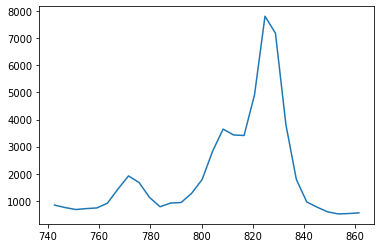

In [3]:
# Extract relevant p-xylene region and Vinyl region.

pxyl_Region = df.iloc[0, 150:180] # Extract 1st spectra at the pxyl region and plot.
pxyl_Region.index = pxyl_Region.index.astype(float) # Change the index type to float.
pxyl_Region.plot()
plt.show()

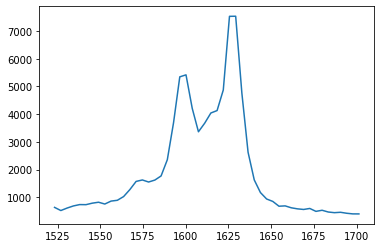

In [4]:
Vinyl_Region = df.iloc[0, 350:400] # Extract 1st spectra at the Vinyl region and plot.
Vinyl_Region.index = Vinyl_Region.index.astype(float) # Change the index type to float.
Vinyl_Region.plot()
plt.show()

# Baseline Subtraction

## Custom

Choose two regions on the spectrum that you want to form the basis for the baseline. The spectrum is based on the truncated region of interest from the raw spectrum.

Choose from the curve above, <10 and >50 to form the x and y values to fit a polynomial line, serving as my baseline values. **Note that the x-axis is the placeholder index location of the truncated spectra, not the actual wavenumbers themselves**

Ar Region Baseline Subtraction

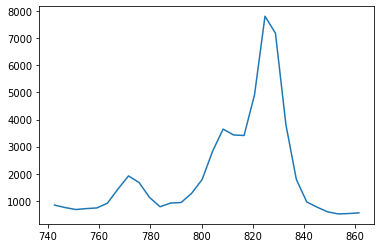

In [5]:
# Ar Region Baseline Subtraction
y = df.iloc[0, 150:180]
y.index = y.index.astype('float')
y.plot()
plt.show()

# y is a Series. A pandas Series is a lablled/ indexed 1-D array. Therefore, a single argument of y,
# itself containing the intensity value (y-axis) at the corresponding wavenumber (x-axis) can be plotted. 

# Plot the 1st spectra (1st row) of df_t0.

In [6]:
xbl = [] # x-baseline.

for items in y.index[:5].values.tolist():
    xbl.append(items)

for items in y.index[25:].values.tolist():
    xbl.append(items)

# Recall that y is a Series with intensities labelled by their wavenumbers. y.index gives the Series labels, which are the 
# wavenumbers. y.index[:10] gives the 0th to 9th Series labels and is an index object. Convert the index object to a numpy
# array via y.index[:10].values, then put them into a list via y.index[:10].values.tolist().

# There are 2 for loops for the xbl (x baseline) list because you want the 1st 10 wavenumbers, but you also want the last
# wavenumbers from index 40 onwards. In the end, xbl is a single list containing all wavenumbers from index 0 to 9,
# and then from index 40 onwards. The same ideas apply for ybl, except for the fact that ybl contains intensities.

ybl = [] # y-baseline.

for items in y.values[:5].tolist():
    ybl.append(items)

for items in y.values[25:].tolist():
    ybl.append(items)
    
# y is a Pandas Series. Therefore, y.values immediately gives the values witihn that series, which are the intensities.

In [7]:
# Check that the range of xbl and ybl values makes sense.
xbl_and_ybl = list(zip(xbl, ybl))# Zip xbl and ybl together, then use list function to unpack the zipped object.
xbl_and_ybl

[(742.613894, 846.0),
 (746.74227, 757.0),
 (750.870737, 684.0),
 (754.997312, 718.0),
 (759.120019, 742.0),
 (845.15714, 769.0),
 (849.226926, 598.0),
 (853.294865, 522.0),
 (857.360957, 535.0),
 (861.425203, 561.0)]

Running the baseline fit. **(x-values, y-values, polynomial degree)** are the arguments.

In [8]:
blpars = np.polyfit(xbl, ybl, 1)
# blpars contains the baseline parameters; the coefficients which will allow for the baseline polynomial to be defined.
# Fit a polynomial based on the x and y-values chosen for the spectra during the previous step. Thus, given a list of x values
# and its corresponding y-values, fit a polynomial through these points as best as you can. This polynomial will serve as the 
# baseline to be subtracted from the spectra's y-values. 
# numpy.polyfit(x, y, deg)
# np.polyfit: Least squares polynomial fit. Fit a polynomial p(x) = p[0] * x**deg + ... + p[deg] of degree deg to points (x, y).
# Returns a vector of coefficients p that minimises the squared error in the order deg, deg-1, … 0.
# Since degree = 1, we are fitting a straight line.

blfit = np.poly1d(blpars)
# A one-dimensional polynomial class. A convenience class, used to encapsulate “natural” operations on polynomials so that
# said operations may take on their customary form in code. blfit is a function that encompasses information on blpar's vector
# of coefficients derived from the np.polyfit step. It will take an input of x-values, then apply the coefficients to the
# x-values to obtain the best fit polynomial following the p(x) equation defined above.

Plot showing before and after subtraction.

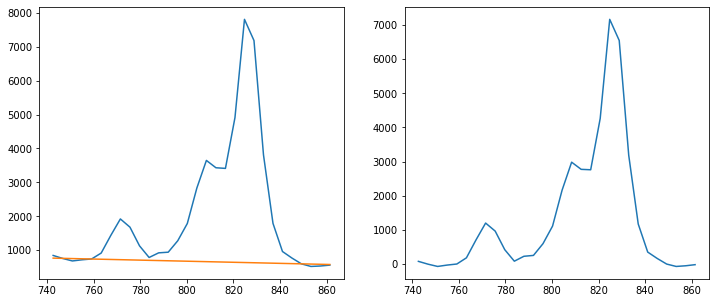

In [9]:
plt.figure(figsize = (12,5))

plt.subplot(1,2,1) # subplot(nrows, ncols, index)
plt.plot(y) # Plot the spectrum using the Series y.
plt.plot(y.index, blfit(y.index))
# Plot the baseline polynomial to be subtracted (orange color). The x-axis will contain the wavenumbers. 
# Therefore y.index(Series labels) is being plotted at the x-axis. The y-axis will be blfit(y.index) because the output of 
# blfit(y.index) contains the y-values of the polynomial that is best fit to the input x-values.

plt.subplot(1,2,2)
plt.plot(y.index,(y - blfit(y.index)))
# Plot the baseline corrected spectrum. Subtraction can immediately be done because blfit(y.index) is a numpy array of y-values
# of the best fit polynomial. So the each value in Series y will minus each value in array blfit(y.index),
# to yield a final y value, which is the corrected spectra intensity. 

plt.show()

Vinyl Region Baseline Subtraction

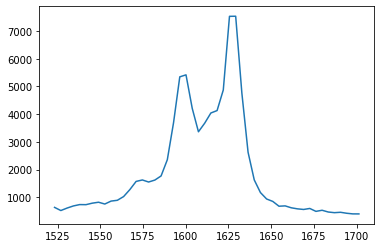

In [10]:
# Vinyl Region Baseline Subtraction
y = df.iloc[0, 350:400]
y.index = y.index.astype('float')
y.plot()
plt.show()

In [11]:
xbl = []

for items in y.index[:10].values.tolist():
    xbl.append(items)

for items in y.index[40:].values.tolist():
    xbl.append(items)
    
ybl = []

for items in y.values[:10].tolist():
    ybl.append(items)

for items in y.values[40:].tolist():
    ybl.append(items)

In [12]:
xbl_and_ybl = list(zip(xbl, ybl))
xbl_and_ybl

[(1523.22227, 633.0),
 (1526.906523, 519.0),
 (1530.589202, 609.0),
 (1534.270309, 685.0),
 (1537.948031, 734.0),
 (1541.625996, 731.0),
 (1545.30058, 785.0),
 (1548.971787, 819.0),
 (1552.643239, 754.0),
 (1556.309509, 860.0),
 (1669.014197, 558.0),
 (1672.616805, 594.0),
 (1676.219678, 489.0),
 (1679.817468, 529.0),
 (1683.415525, 466.0),
 (1687.010287, 442.0),
 (1690.603536, 456.0),
 (1694.195274, 421.0),
 (1697.785502, 398.0),
 (1701.370664, 397.0)]

In [13]:
blpars = np.polyfit(xbl, ybl, 1)
blfit = np.poly1d(blpars)

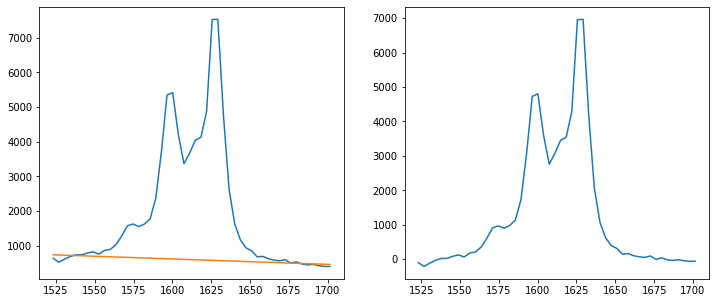

In [14]:
plt.figure(figsize = (12,5))

plt.subplot(1,2,1)
plt.plot(y)
plt.plot(y.index, blfit(y.index))

plt.subplot(1,2,2)
plt.plot(y.index,(y - blfit(y.index))) 

plt.show()

# Fitting Functions

In [15]:
from lmfit import Minimizer, Parameters, report_fit
from lmfit.lineshapes import gaussian, lorentzian, split_lorentzian

def residuals(pars,x,y):
    
    model =  (lorentzian(x, pars['ampL1'], pars['cenL1'], pars['widL1']) +
              lorentzian(x, pars['ampL2'], pars['cenL2'], pars['widL2']))
    
    return model - y

# Running Curve Fits

In [16]:
df_vinyl = df.iloc[:, 350:400].copy()
df_vinyl.columns = df_vinyl.columns.astype('float')
df_vinyl

,1523.222270,1526.906523,1530.589202,1534.270309,1537.948031,1541.625996,1545.300580,1548.971787,1552.643239,1556.309509,...,1669.014197,1672.616805,1676.219678,1679.817468,1683.415525,1687.010287,1690.603536,1694.195274,1697.785502,1701.370664
0,633.0,519.0,609.0,685.0,734.0,731.0,785.0,819.0,754.0,860.0,...,558.0,594.0,489.0,529.0,466.0,442.0,456.0,421.0,398.0,397.0
1,617.0,591.0,564.0,620.0,667.0,698.0,740.0,779.0,735.0,775.0,...,532.0,557.0,455.0,463.0,514.0,439.0,433.0,425.0,431.0,380.0
2,630.0,613.0,616.0,632.0,703.0,690.0,709.0,685.0,731.0,839.0,...,561.0,513.0,474.0,380.0,515.0,468.0,453.0,384.0,451.0,348.0
3,571.0,528.0,575.0,616.0,691.0,627.0,746.0,801.0,682.0,709.0,...,510.0,513.0,491.0,467.0,479.0,399.0,418.0,369.0,378.0,343.0
4,666.0,583.0,541.0,659.0,754.0,704.0,701.0,773.0,705.0,844.0,...,579.0,542.0,541.0,434.0,429.0,371.0,468.0,394.0,413.0,379.0
5,601.0,547.0,589.0,631.0,718.0,709.0,680.0,778.0,732.0,821.0,...,616.0,510.0,441.0,443.0,489.0,464.0,426.0,409.0,447.0,396.0
6,582.0,521.0,577.0,562.0,697.0,773.0,702.0,678.0,666.0,742.0,...,523.0,491.0,423.0,404.0,476.0,415.0,441.0,409.0,394.0,365.0
7,634.0,594.0,550.0,598.0,658.0,764.0,708.0,804.0,738.0,834.0,...,574.0,498.0,460.0,460.0,508.0,450.0,442.0,351.0,421.0,353.0
8,599.0,628.0,621.0,598.0,588.0,707.0,741.0,762.0,680.0,810.0,...,551.0,500.0,517.0,557.0,481.0,507.0,455.0,402.0,394.0,402.0
9,610.0,585.0,636.0,561.0,746.0,656.0,722.0,761.0,726.0,836.0,...,572.0,578.0,428.0,498.0,510.0,423.0,457.0,433.0,419.0,400.0


For 2 Lorentzians peak fits within the region of interest:

## Select initial guess parameters, namely amplitude, centre, width of the peaks.

In [17]:
ampL1 = 170000 # Peak Amplitude of 1st Peak
cenL1 = 1599 # Peak location of 1st Peak
widL1 = 7

ampL2 = 240000 # Peak Amplitude of 2nd Peak
cenL2 = 1627 # Peak location of 2nd Peak
widL2 = 5

## Fitting and Plotting (Vinyl Region)

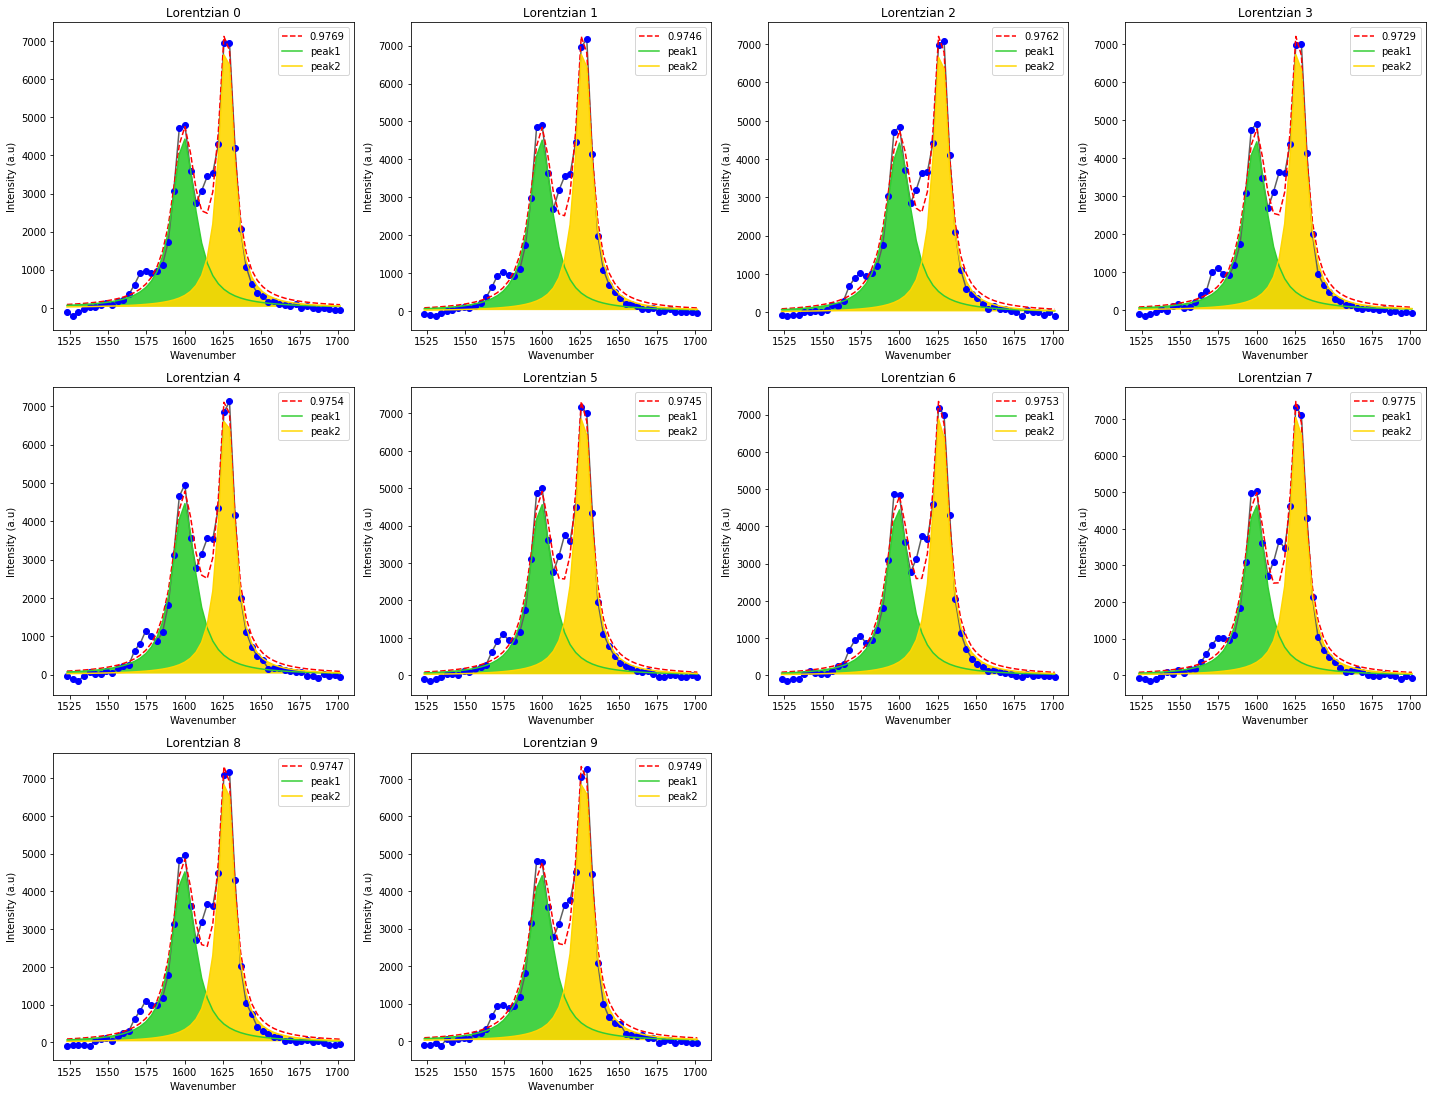

In [18]:
de = collections.deque([])
Area_1 = collections.deque([])
Area_2 = collections.deque([])

pbar = tqdm(total = len(df_vinyl), dynamic_ncols  = True, desc = 'Fitting curves')

plt.figure(figsize = (20,20))

pfit = Parameters()
pfit.add(name='ampL1', value = ampL1, min = 0)
pfit.add(name='ampL2', value = ampL2, min = 0)
pfit.add(name='cenL1', value = cenL1, max = 1605)
pfit.add(name='cenL2', value = cenL2, min = 1620, max = 1640)
pfit.add(name='widL1', value = widL1, min = 0)
pfit.add(name='widL2', value = widL2, min = 0)

for i,item in df_vinyl.iterrows():
    
    x = df_vinyl.columns # Wavenumbers
    
    y = item # Intensities
    
    xbl = []

    for items in y.index[:10].values.tolist():
        xbl.append(items)

    for items in y.index[40:].values.tolist():
        xbl.append(items)


    ybl = []

    for items in y.values[:10].tolist():
        ybl.append(items)

    for items in y.values[40:].tolist():
        ybl.append(items)
    
    blpars = np.polyfit(xbl, ybl, 1)
    blfit = np.poly1d(blpars)
    
    y -= blfit(x) # Corrected Intensities

    mini = Minimizer(residuals, pfit, fcn_args=(x, y))
    out = mini.leastsq()
    best_fit = y + out.residual
    
    fit_params = out.params.valuesdict()
    fit_params['R2'] = r2_score(y,best_fit)
    fit_params['FWHM_L1'] = 2*out.params.valuesdict()['widL1']
    fit_params['FWHM_L2'] = 2*out.params.valuesdict()['widL2']
    fit_params['Height_L1'] = 0.3183099*out.params.valuesdict()['ampL1']/max(2.220446049250313e-16, out.params.valuesdict()['widL1'])
    fit_params['Height_L2'] = 0.3183099*out.params.valuesdict()['ampL2']/max(2.220446049250313e-16, out.params.valuesdict()['widL2'])
    
    
    results = de.append(fit_params)
    
    peak1 = lorentzian(x,out.params.valuesdict()['ampL1'], out.params.valuesdict()['cenL1'], out.params.valuesdict()['widL1'])
    peak2 = lorentzian(x,out.params.valuesdict()['ampL2'], out.params.valuesdict()['cenL2'], out.params.valuesdict()['widL2'])
    
    plt.subplot(np.ceil(np.sqrt(df_vinyl.shape[0])),np.ceil(np.sqrt(df_vinyl.shape[0])),(1+i))
    plt.title('Lorentzian ' + str(i))
    plt.xlabel('Wavenumber')
    plt.ylabel('Intensity (a.u)')
    plt.plot(x, y, '#606060')
    plt.plot(x, y, 'bo')
    plt.plot(x, best_fit, 'r--', label = str(fit_params['R2'].round(decimals = 4)))
    plt.plot(x, peak1,'#32CD32', label = 'peak1')
    plt.fill_between(x, peak1.min(), peak1, facecolor = '#32CD32', alpha = 0.9)
    plt.plot(x, peak2,'#FFD700', label = 'peak2')
    plt.fill_between(x, peak2.min(), peak2, facecolor = '#FFD700', alpha = 0.9)
    plt.legend(loc='best')
   
    Area_1.append(integrate.simps(peak1, x)) 
    Area_2.append(integrate.simps(peak2, x))
    
    pbar.update(1)
    
pbar.close()
    
plt.tight_layout()
plt.show()

In [19]:
results = pd.DataFrame(de)
results.rename(columns={'R2':'R2_Vinyl'}, inplace=True)
results

,ampL1,ampL2,cenL1,cenL2,widL1,widL2,R2_Vinyl,FWHM_L1,FWHM_L2,Height_L1,Height_L2
0,127857.887362,132435.414067,1599.471180,1627.213351,9.133158,5.916012,0.976944,18.266315,11.832025,4456.118333,7125.661887
1,127455.042203,135644.094685,1599.460726,1627.162141,8.945437,5.979337,0.974588,17.890874,11.958673,4535.295706,7221.011475
2,134437.823776,132364.323452,1599.785518,1627.186400,9.671768,5.912306,0.976209,19.343537,11.824612,4424.515606,7126.301344
3,127584.184660,134137.059439,1599.335103,1627.102027,9.094764,5.985500,0.972875,18.189529,11.971000,4465.350300,7133.431195
4,130353.739863,132499.939671,1599.540427,1627.280820,9.257324,5.917952,0.975433,18.514647,11.835904,4482.168707,7126.796931
5,127866.845827,139069.109761,1599.349975,1627.060990,8.851085,6.122029,0.974482,17.702170,12.244058,4598.451324,7230.784792
6,127107.250723,140435.945945,1599.265576,1626.992268,9.018407,6.190168,0.975301,18.036814,12.380337,4486.324089,7221.475909
7,125455.538601,141382.610994,1599.152892,1627.033246,8.503725,6.062403,0.977459,17.007449,12.124807,4696.029229,7423.373543
8,129597.307511,137030.247698,1599.356998,1627.175813,9.062523,5.987400,0.974682,18.125046,11.974800,4551.945089,7284.979383
9,128887.126245,139540.083550,1599.327713,1627.223738,9.209918,6.062919,0.974901,18.419836,12.125838,4454.550924,7326.007528


In [20]:
results.describe() 

,ampL1,ampL2,cenL1,cenL2,widL1,widL2,R2_Vinyl,FWHM_L1,FWHM_L2,Height_L1,Height_L2
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,128660.274677,136453.882926,1599.404611,1627.143079,9.074811,6.013603,0.975287,18.149622,12.027205,4515.074931,7221.982399
std,2443.665657,3517.813593,0.173143,0.092472,0.299627,0.093885,0.001325,0.599254,0.187770,82.452927,100.421897
min,125455.538601,132364.323452,1599.152892,1626.992268,8.503725,5.912306,0.972875,17.007449,11.824612,4424.515606,7125.661887
25%,127487.327817,132909.219613,1599.329561,1627.071250,8.963679,5.933298,0.974612,17.927359,11.866596,4458.426325,7128.455497
50%,127862.366595,136337.171192,1599.353487,1627.168977,9.078644,5.986450,0.975101,18.157287,11.972900,4484.246398,7221.243692
75%,129419.762195,139422.340103,1599.468566,1627.206613,9.190728,6.062790,0.976015,18.381456,12.125580,4547.782744,7271.430735
max,134437.823776,141382.610994,1599.785518,1627.280820,9.671768,6.190168,0.977459,19.343537,12.380337,4696.029229,7423.373543


For 2 Lorentzians peak fits within the region of interest:

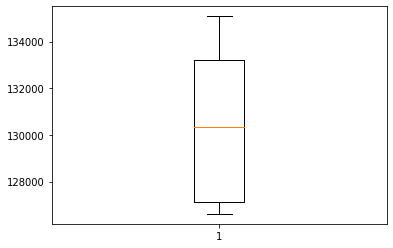

In [21]:
plt.boxplot(Area_2)
plt.show()

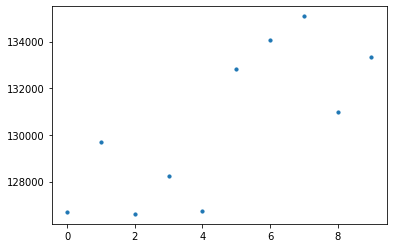

In [22]:
plt.scatter(range(len(Area_2)), Area_2, s=10)
plt.show()

In [23]:
Area_2 = pd.Series(Area_2)
labels = df.iloc[:, 0:1]
df_area = pd.concat([labels, Area_2, results['R2_Vinyl']], axis=1)
df_area.rename(columns={0: 'Vinyl Peak Area'}, inplace=True)
df_area

,Original Spectral Index,Vinyl Peak Area,R2_Vinyl
0,160,126674.793744,0.976944
1,161,129683.518141,0.974588
2,162,126611.098477,0.976209
3,163,128238.544134,0.972875
4,164,126732.810899,0.975433
5,165,132817.767098,0.974482
6,166,134056.021707,0.975301
7,167,135089.157764,0.977459
8,168,131000.382825,0.974682
9,169,133322.308963,0.974901


# Fitting and Plotting (p-xylene Region)

In [24]:
df_pxyl = df.iloc[:, 150:180].copy()
df_pxyl.columns = df_pxyl.columns.astype('float')
df_pxyl

,742.613894,746.742270,750.870737,754.997312,759.120019,763.240838,767.359772,771.474846,775.588038,779.699351,...,824.764725,828.847705,832.928828,837.008094,841.083543,845.157140,849.226926,853.294865,857.360957,861.425203
0,846.0,757.0,684.0,718.0,742.0,917.0,1436.0,1922.0,1680.0,1129.0,...,7805.0,7180.0,3811.0,1791.0,962.0,769.0,598.0,522.0,535.0,561.0
1,810.0,676.0,689.0,617.0,749.0,920.0,1455.0,2055.0,1825.0,1087.0,...,7860.0,7087.0,4060.0,1686.0,939.0,699.0,629.0,497.0,542.0,552.0
2,777.0,725.0,746.0,741.0,815.0,931.0,1489.0,1962.0,1863.0,1120.0,...,7735.0,7169.0,3872.0,1773.0,929.0,682.0,616.0,505.0,520.0,501.0
3,710.0,705.0,681.0,602.0,726.0,996.0,1446.0,2008.0,1803.0,1144.0,...,7896.0,6961.0,3874.0,1711.0,944.0,833.0,587.0,524.0,568.0,555.0
4,766.0,793.0,705.0,697.0,836.0,968.0,1426.0,1949.0,1826.0,1135.0,...,7752.0,7029.0,3921.0,1689.0,1012.0,791.0,680.0,455.0,490.0,521.0
5,746.0,708.0,689.0,723.0,838.0,1011.0,1455.0,2026.0,1844.0,1185.0,...,7743.0,7254.0,3896.0,1669.0,989.0,739.0,584.0,542.0,528.0,468.0
6,678.0,679.0,660.0,712.0,754.0,954.0,1475.0,1961.0,1885.0,1094.0,...,7976.0,7185.0,3935.0,1756.0,945.0,781.0,568.0,561.0,536.0,562.0
7,800.0,727.0,666.0,681.0,759.0,1025.0,1452.0,1810.0,1757.0,1186.0,...,7844.0,7206.0,3937.0,1663.0,940.0,817.0,590.0,527.0,523.0,613.0
8,717.0,712.0,687.0,713.0,774.0,1008.0,1461.0,2021.0,1780.0,1164.0,...,7903.0,7059.0,3833.0,1862.0,905.0,791.0,601.0,510.0,507.0,466.0
9,829.0,628.0,656.0,714.0,738.0,973.0,1488.0,2053.0,1777.0,1166.0,...,7949.0,7175.0,3996.0,1719.0,1029.0,791.0,634.0,493.0,542.0,567.0


In [25]:
def residuals(pars,x,y):
    
    model =  (lorentzian(x, pars['ampL1'], pars['cenL1'], pars['widL1']) +
              lorentzian(x, pars['ampL2'], pars['cenL2'], pars['widL2']) +
              split_lorentzian(x, pars['ampL3'], pars['cenL3'], pars['widL3'],pars['widL4']))
    
    return model - y

In [26]:
ampL1 = 30000
cenL1 = 773 
widL1 = 3

ampL2 = 35000 
cenL2 = 809
widL2 = 5

ampL3 = 150000
cenL3 = 827
widL3 = 6
widL4 = 4

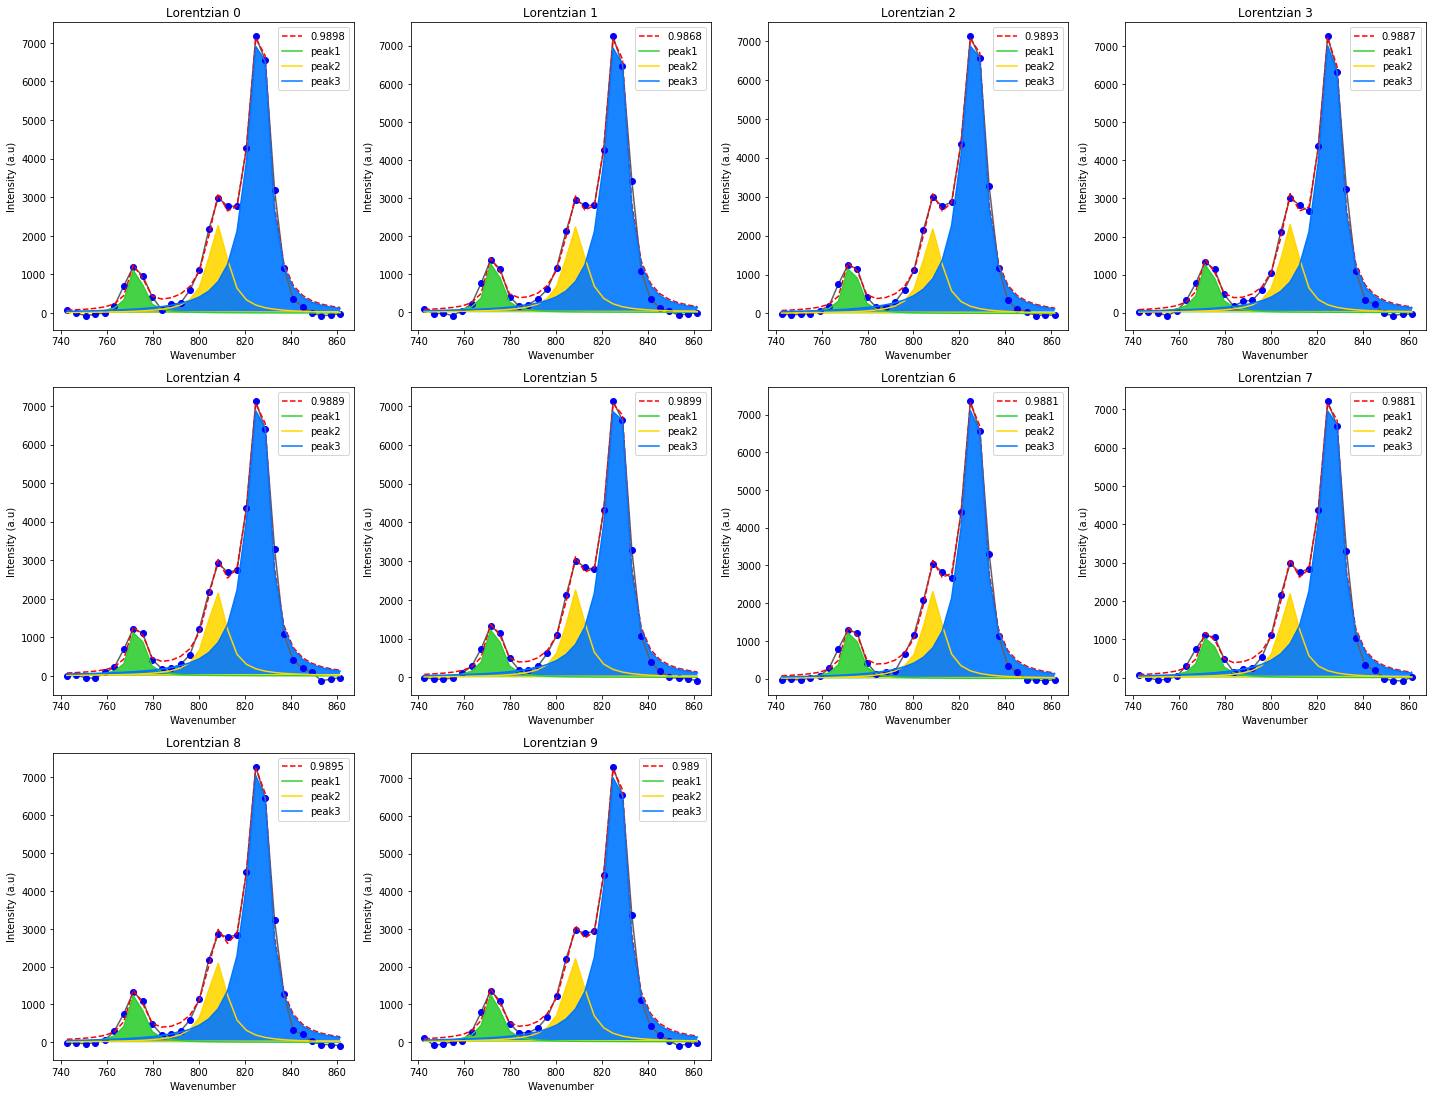

In [27]:
de = collections.deque([])
Area_1 = collections.deque([])
Area_2 = collections.deque([])
Area_3 = collections.deque([])

pbar = tqdm(total = len(df_pxyl), dynamic_ncols  = True, desc = 'Fitting curves')

plt.figure(figsize = (20,20))

pfit = Parameters()
pfit.add(name='ampL1', value = ampL1, min = 0)
pfit.add(name='ampL2', value = ampL2, min = 0)
pfit.add(name='ampL3', value = ampL3, min = 0)
pfit.add(name='cenL1', value = cenL1, min = 770, max = 780)
pfit.add(name='cenL2', value = cenL2, min = 805, max = 815)
pfit.add(name='cenL3', value = cenL3, min = 820, max = 830)
pfit.add(name='widL1', value = widL1, min = 0)
pfit.add(name='widL2', value = widL2, min = 0)
pfit.add(name='widL3', value = widL3, min = 0)
pfit.add(name='widL4', value = widL4, min = 0)

for i,item in df_pxyl.iterrows():
    
    x = df_pxyl.columns # Wavenumbers
    
    y = item # Intensities
    
    xbl = []

    for items in y.index[:5].values.tolist():
        xbl.append(items)

    for items in y.index[25:].values.tolist():
        xbl.append(items)


    ybl = []

    for items in y.values[:5].tolist():
        ybl.append(items)

    for items in y.values[25:].tolist():
        ybl.append(items)
    
    blpars = np.polyfit(xbl, ybl, 1)
    blfit = np.poly1d(blpars)
    
    y -= blfit(x) # Corrected Intensities

    mini = Minimizer(residuals, pfit, fcn_args=(x, y))
    out = mini.leastsq()
    best_fit = y + out.residual
    
    fit_params = out.params.valuesdict()
    fit_params['R2'] = r2_score(y,best_fit)
    fit_params['FWHM_L1'] = 2*out.params.valuesdict()['widL1']
    fit_params['FWHM_L2'] = 2*out.params.valuesdict()['widL2']
    fit_params['FWHM_L3'] = out.params.valuesdict()['widL3'] + out.params.valuesdict()['widL4']
    fit_params['Height_L1'] = 0.318309886*out.params.valuesdict()['ampL1']/max(2.220446049250313e-16, out.params.valuesdict()['widL1'])
    fit_params['Height_L2'] = 0.318309886*out.params.valuesdict()['ampL2']/max(2.220446049250313e-16, out.params.valuesdict()['widL2'])
    fit_params['Height_L3'] = 0.318309886*out.params.valuesdict()['ampL3']/max(2.220446049250313e-16, out.params.valuesdict()['widL3']+out.params.valuesdict()['widL4'])
    
    results = de.append(fit_params)
    
    peak1 = lorentzian(x,out.params.valuesdict()['ampL1'], out.params.valuesdict()['cenL1'], out.params.valuesdict()['widL1'])
    peak2 = lorentzian(x,out.params.valuesdict()['ampL2'], out.params.valuesdict()['cenL2'], out.params.valuesdict()['widL2'])
    peak3 = split_lorentzian(x,out.params.valuesdict()['ampL3'], out.params.valuesdict()['cenL3'], out.params.valuesdict()['widL3'], out.params.valuesdict()['widL4'])
    
    plt.subplot(np.ceil(np.sqrt(df_pxyl.shape[0])),np.ceil(np.sqrt(df_pxyl.shape[0])),(1+i))
    plt.title('Lorentzian ' + str(i))
    plt.xlabel('Wavenumber')
    plt.ylabel('Intensity (a.u)')
    plt.plot(x, y, '#606060')
    plt.plot(x, y, 'bo')
    plt.plot(x, best_fit, 'r--', label = str(fit_params['R2'].round(decimals = 4)))
    plt.plot(x, peak1,'#32CD32', label = 'peak1')
    plt.fill_between(x, peak1.min(), peak1, facecolor = '#32CD32', alpha = 0.9)
    plt.plot(x, peak2,'#FFD700', label = 'peak2')
    plt.fill_between(x, peak2.min(), peak2, facecolor = '#FFD700', alpha = 0.9)
    plt.plot(x, peak3,'#0077FF', label = 'peak3')
    plt.fill_between(x, peak3.min(), peak3, facecolor = '#0077FF', alpha = 0.9)
    plt.legend(loc='best')
   
    Area_1.append(integrate.simps(peak1, x)) 
    Area_2.append(integrate.simps(peak2, x))
    Area_3.append(integrate.simps(peak3, x))
    
    pbar.update(1)
    
plt.tight_layout()
plt.show()

In [28]:
results = pd.DataFrame(de)
results.rename(columns={'R2':'R2_pxyl'}, inplace=True)
results

,ampL1,ampL2,ampL3,cenL1,cenL2,cenL3,widL1,widL2,widL3,widL4,R2_pxyl,FWHM_L1,FWHM_L2,FWHM_L3,Height_L1,Height_L2,Height_L3
0,12893.124156,37068.026604,129802.201683,772.774440,808.330233,826.993881,3.195641,5.211404,6.378457,4.282812,0.989846,6.391281,10.422808,10.661269,1284.252331,2264.096167,3875.460246
1,15232.932236,38064.078187,130818.246696,772.934625,808.438321,826.904640,3.124673,5.419991,6.312287,4.455753,0.986835,6.249346,10.839983,10.768040,1551.776014,2235.459734,3867.067991
2,14130.706121,34472.908242,133812.940431,773.163714,808.216556,827.076197,2.986636,5.048218,6.778929,4.337082,0.989295,5.973271,10.096436,11.116011,1506.023446,2173.651751,3831.768748
3,16113.286255,36822.969934,129436.645543,772.805248,808.474699,826.770570,3.604029,5.070463,6.243259,4.401316,0.988656,7.208058,10.140926,10.644575,1423.134673,2311.645930,3870.606829
4,13749.830038,34737.182835,132411.630940,773.147491,807.925245,826.939398,2.980719,5.116023,6.639424,4.432965,0.988857,5.961438,10.232046,11.072389,1468.339369,2161.285903,3806.579559
5,15478.269677,36357.144513,131622.845334,772.947852,808.528903,827.111082,3.395966,5.138168,6.565171,4.269978,0.989903,6.791932,10.276337,10.835148,1450.805439,2252.327571,3866.753943
6,15499.233928,36736.426620,131717.512026,773.126984,808.489926,826.867688,3.240945,5.068364,6.240422,4.362088,0.988084,6.481891,10.136728,10.602510,1522.259394,2307.168193,3954.439635
7,13804.573800,34165.638686,133549.210092,773.013607,808.226189,827.043017,3.639920,4.980212,6.679312,4.277769,0.988141,7.279841,9.960424,10.957081,1207.205644,2183.694253,3879.686172
8,15331.707025,34806.892720,134707.543243,772.730657,808.125211,826.856251,3.522647,5.303995,6.636823,4.431748,0.989468,7.045294,10.607990,11.068571,1385.388281,2088.874129,3873.918511
9,15555.090631,38442.146122,134030.895597,772.635200,808.326217,826.937032,3.563662,5.556941,6.570518,4.396885,0.988959,7.127324,11.113882,10.967403,1389.396347,2202.023639,3890.014577


In [29]:
results.describe()

,ampL1,ampL2,ampL3,cenL1,cenL2,cenL3,widL1,widL2,widL3,widL4,R2_pxyl,FWHM_L1,FWHM_L2,FWHM_L3,Height_L1,Height_L2,Height_L3
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,14778.875386,36167.341446,132190.967159,772.927982,808.308150,826.949976,3.325484,5.191378,6.504460,4.364840,0.988804,6.650968,10.382756,10.869300,1418.858094,2218.022727,3871.629621
std,1048.141250,1532.876903,1824.724552,0.186912,0.189286,0.106744,0.252771,0.183283,0.194491,0.069783,0.000935,0.505542,0.366565,0.193082,107.676374,69.615992,38.219181
min,12893.124156,34165.638686,129436.645543,772.635200,807.925245,826.770570,2.980719,4.980212,6.240422,4.269978,0.986835,5.961438,9.960424,10.602510,1207.205644,2088.874129,3806.579559
25%,13886.106880,34754.610306,131019.396355,772.782142,808.218964,826.876926,3.142415,5.068889,6.328829,4.296380,0.988270,6.284830,10.137777,10.687962,1386.390297,2176.162376,3866.832455
50%,15282.319630,36546.785567,132064.571483,772.941238,808.328225,826.938215,3.318456,5.127096,6.567844,4.379487,0.988908,6.636911,10.254192,10.896114,1436.970056,2218.741686,3872.262670
75%,15493.992865,37006.762437,133747.007846,773.098640,808.465605,827.030733,3.553408,5.280847,6.638774,4.424140,0.989425,7.106817,10.561694,11.043279,1496.602427,2261.154018,3878.629690
max,16113.286255,38442.146122,134707.543243,773.163714,808.528903,827.111082,3.639920,5.556941,6.778929,4.455753,0.989903,7.279841,11.113882,11.116011,1551.776014,2311.645930,3954.439635


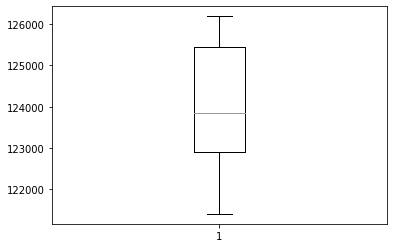

In [30]:
plt.boxplot(Area_3)
plt.show()

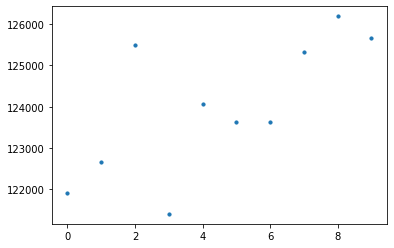

In [31]:
plt.scatter(range(len(Area_3)), Area_3, s=10)
plt.show()

In [32]:
df_area = pd.concat([df_area, pd.Series(Area_3), results['R2_pxyl']], axis=1)
df_area.rename(columns={0: 'pxyl Peak Area'}, inplace=True)
df_area

,Original Spectral Index,Vinyl Peak Area,R2_Vinyl,pxyl Peak Area,R2_pxyl
0,160,126674.793744,0.976944,121913.152559,0.989846
1,161,129683.518141,0.974588,122666.850674,0.986835
2,162,126611.098477,0.976209,125490.842959,0.989295
3,163,128238.544134,0.972875,121407.119041,0.988656
4,164,126732.810899,0.975433,124069.568172,0.988857
5,165,132817.767098,0.974482,123620.104964,0.989903
6,166,134056.021707,0.975301,123625.085131,0.988084
7,167,135089.157764,0.977459,125335.558410,0.988141
8,168,131000.382825,0.974682,126188.656759,0.989468
9,169,133322.308963,0.974901,125654.299444,0.988959


In [33]:
# Keep only columns with R2 values > 0.98 on both R2_Vinyl and R2_pxyl.
df_area = df_area[(df_area['R2_Vinyl'] > 0.97) & (df_area['R2_pxyl'] > 0.97)]

# Normalization
df_area['Vinyl Divide pxyl'] =  df_area['Vinyl Peak Area'] / df_area['pxyl Peak Area']

df_area

,Original Spectral Index,Vinyl Peak Area,R2_Vinyl,pxyl Peak Area,R2_pxyl,Vinyl Divide pxyl
0,160,126674.793744,0.976944,121913.152559,0.989846,1.039058
1,161,129683.518141,0.974588,122666.850674,0.986835,1.057201
2,162,126611.098477,0.976209,125490.842959,0.989295,1.008927
3,163,128238.544134,0.972875,121407.119041,0.988656,1.056269
4,164,126732.810899,0.975433,124069.568172,0.988857,1.021466
5,165,132817.767098,0.974482,123620.104964,0.989903,1.074403
6,166,134056.021707,0.975301,123625.085131,0.988084,1.084376
7,167,135089.157764,0.977459,125335.558410,0.988141,1.077820
8,168,131000.382825,0.974682,126188.656759,0.989468,1.038131
9,169,133322.308963,0.974901,125654.299444,0.988959,1.061025


In [34]:
# View the data
df_area = df_area.describe()
df_area

,Original Spectral Index,Vinyl Peak Area,R2_Vinyl,pxyl Peak Area,R2_pxyl,Vinyl Divide pxyl
count,10.00000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,164.50000,130422.640375,0.975287,123997.123811,0.988804,1.051867
std,3.02765,3282.308916,0.001325,1655.903362,0.000935,0.024700
min,160.00000,126611.098477,0.972875,121407.119041,0.986835,1.008927
25%,162.25000,127109.244208,0.974612,122905.164247,0.988270,1.038363
50%,164.50000,130341.950483,0.975101,123847.326652,0.988908,1.056735
75%,166.75000,133196.173497,0.976015,125452.021822,0.989425,1.071058
max,169.00000,135089.157764,0.977459,126188.656759,0.989903,1.084376


In [35]:
df_area.to_csv(r'C:\Users\Tan Jin Da\Desktop\A STAR\Controlled Polymerization Experiments\200930 Continuous Flow for NMR and Raman Triplicate Experiment 6 (1 mol% AIBN, 85 deg)\Online Raman\df_ss_t90_area.csv')